# Document Clustering with LLM Embeddings



## 1. Install and Import Libraries

In [1]:
# Install required libraries
!pip install sentence-transformers --quiet
!pip install hdbscan --quiet
!pip install umap-learn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set random seed and plotting style
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
print("Base libraries imported successfully!")

Base libraries imported successfully!


In [2]:
# Import embedding and clustering libraries
from sentence_transformers import SentenceTransformer
import hdbscan
import umap

print("Sentence-Transformers and clustering libraries imported!")

Sentence-Transformers and clustering libraries imported!


## 2. Create Sample Document Dataset

In [3]:
# Create a sample dataset with documents from different categories
documents = [
    # Technology (Category 0)
    "The new smartphone features an advanced AI chip for better performance.",
    "Machine learning algorithms are transforming how we process data.",
    "Cloud computing enables businesses to scale their infrastructure easily.",
    "Cybersecurity threats continue to evolve with new attack vectors.",
    "The latest software update includes important security patches.",
    "Artificial intelligence is revolutionizing healthcare diagnostics.",
    "Programming languages like Python are essential for data science.",
    "Virtual reality headsets are becoming more affordable and powerful.",
    "Quantum computing promises to solve complex problems faster.",
    "The tech industry is investing heavily in renewable energy solutions.",

    # Sports (Category 1)
    "The basketball team won the championship after an exciting final game.",
    "Soccer players are training hard for the upcoming World Cup.",
    "The tennis tournament attracted thousands of spectators worldwide.",
    "Olympic athletes are preparing for the summer games in Paris.",
    "The football quarterback threw three touchdown passes in the game.",
    "Marathon runners completed the race despite challenging weather.",
    "The golf tournament featured some of the world's best players.",
    "Swimming records were broken at the international competition.",
    "Baseball season tickets are selling out quickly this year.",
    "The hockey team celebrated their first championship in decades.",

    # Finance (Category 2)
    "Stock market indices reached new all-time highs this quarter.",
    "Interest rates remain stable despite economic uncertainty.",
    "Cryptocurrency investments have become increasingly popular.",
    "The central bank announced new monetary policy measures.",
    "Investment portfolios should be diversified for risk management.",
    "Corporate earnings reports exceeded analyst expectations.",
    "The bond market is showing signs of increased volatility.",
    "Inflation rates are affecting consumer purchasing power.",
    "Mutual funds offer a way to invest in diverse securities.",
    "The financial sector is adopting blockchain technology.",

    # Health (Category 3)
    "Regular exercise improves cardiovascular health and mental wellbeing.",
    "A balanced diet is essential for maintaining good health.",
    "Medical researchers are developing new treatments for cancer.",
    "Vaccination programs have significantly reduced disease rates.",
    "Mental health awareness is increasing in workplaces and schools.",
    "Sleep quality affects cognitive function and immune system.",
    "Hospitals are implementing new patient care technologies.",
    "Preventive healthcare can reduce long-term medical costs.",
    "Nutrition science reveals the importance of micronutrients.",
    "Telemedicine is making healthcare more accessible globally.",

    # Environment (Category 4)
    "Climate change is causing more frequent extreme weather events.",
    "Renewable energy sources are becoming more cost-effective.",
    "Deforestation threatens biodiversity in tropical regions.",
    "Ocean pollution is affecting marine ecosystems worldwide.",
    "Electric vehicles are helping reduce carbon emissions.",
    "Sustainable farming practices protect soil and water resources.",
    "Wildlife conservation efforts are crucial for endangered species.",
    "Recycling programs help reduce waste in landfills.",
    "Air quality improvements are linked to public health benefits.",
    "Green building standards promote energy-efficient construction."
]

# True labels
categories = (
    ['Technology'] * 10 +
    ['Sports'] * 10 +
    ['Finance'] * 10 +
    ['Health'] * 10 +
    ['Environment'] * 10
)

# Create DataFrame
df = pd.DataFrame({
    'document': documents,
    'category': categories
})

# Encode labels
le = LabelEncoder()
y_true = le.fit_transform(categories)

print(f"Total documents: {len(documents)}")
print(f"Categories: {le.classes_}")
print(f"\nSample documents:")
print(df.head(10))

Total documents: 50
Categories: ['Environment' 'Finance' 'Health' 'Sports' 'Technology']

Sample documents:
                                            document    category
0  The new smartphone features an advanced AI chi...  Technology
1  Machine learning algorithms are transforming h...  Technology
2  Cloud computing enables businesses to scale th...  Technology
3  Cybersecurity threats continue to evolve with ...  Technology
4  The latest software update includes important ...  Technology
5  Artificial intelligence is revolutionizing hea...  Technology
6  Programming languages like Python are essentia...  Technology
7  Virtual reality headsets are becoming more aff...  Technology
8  Quantum computing promises to solve complex pr...  Technology
9  The tech industry is investing heavily in rene...  Technology


## 3. Generate Document Embeddings

In [4]:
# Load different embedding models
print("Loading embedding models...")

# Model 1: all-MiniLM-L6-v2 (fast and efficient)
model_minilm = SentenceTransformer('all-MiniLM-L6-v2')
print("✓ Loaded all-MiniLM-L6-v2")

# Model 2: all-mpnet-base-v2 (higher quality)
model_mpnet = SentenceTransformer('all-mpnet-base-v2')
print("✓ Loaded all-mpnet-base-v2")

print("\nModels loaded successfully!")

Loading embedding models...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Loaded all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Loaded all-mpnet-base-v2

Models loaded successfully!


In [5]:
# Generate embeddings
print("Generating embeddings...")

# MiniLM embeddings
embeddings_minilm = model_minilm.encode(documents, show_progress_bar=True)
print(f"MiniLM embeddings shape: {embeddings_minilm.shape}")

# MPNet embeddings
embeddings_mpnet = model_mpnet.encode(documents, show_progress_bar=True)
print(f"MPNet embeddings shape: {embeddings_mpnet.shape}")

Generating embeddings...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

MiniLM embeddings shape: (50, 384)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

MPNet embeddings shape: (50, 768)


## 4. Visualize Embeddings

In [6]:
# Use UMAP for dimensionality reduction and visualization
print("Reducing dimensions with UMAP...")

# UMAP for MiniLM
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=10, min_dist=0.1)
embeddings_minilm_2d = umap_reducer.fit_transform(embeddings_minilm)

# UMAP for MPNet
embeddings_mpnet_2d = umap_reducer.fit_transform(embeddings_mpnet)

print("Dimensionality reduction complete!")

Reducing dimensions with UMAP...
Dimensionality reduction complete!


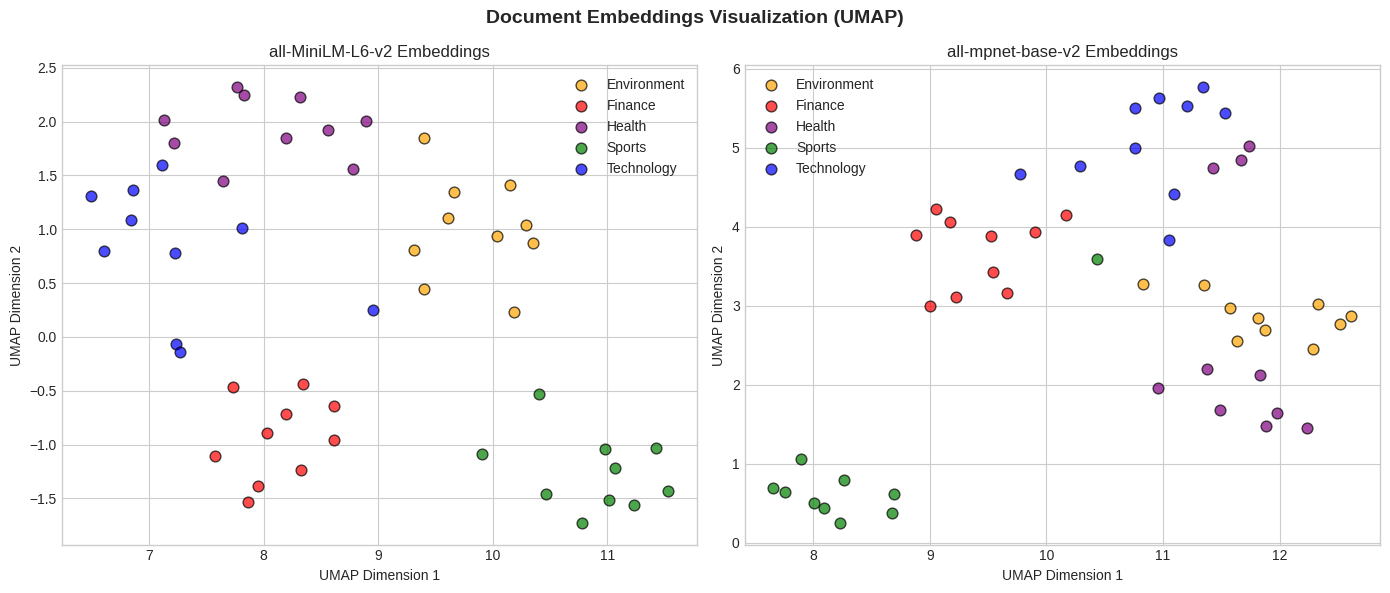

In [7]:
# Visualize embeddings
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'Technology': 'blue', 'Sports': 'green', 'Finance': 'red',
          'Health': 'purple', 'Environment': 'orange'}

# MiniLM embeddings
for cat in le.classes_:
    mask = np.array(categories) == cat
    axes[0].scatter(embeddings_minilm_2d[mask, 0], embeddings_minilm_2d[mask, 1],
                    c=colors[cat], label=cat, alpha=0.7, s=60, edgecolors='k')
axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')
axes[0].set_title('all-MiniLM-L6-v2 Embeddings')
axes[0].legend()

# MPNet embeddings
for cat in le.classes_:
    mask = np.array(categories) == cat
    axes[1].scatter(embeddings_mpnet_2d[mask, 0], embeddings_mpnet_2d[mask, 1],
                    c=colors[cat], label=cat, alpha=0.7, s=60, edgecolors='k')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')
axes[1].set_title('all-mpnet-base-v2 Embeddings')
axes[1].legend()

plt.suptitle('Document Embeddings Visualization (UMAP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. K-Means Clustering on Embeddings

In [8]:
# Apply K-Means clustering
n_clusters = 5

# K-Means on MiniLM embeddings
kmeans_minilm = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_minilm = kmeans_minilm.fit_predict(embeddings_minilm)

# K-Means on MPNet embeddings
kmeans_mpnet = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_mpnet = kmeans_mpnet.fit_predict(embeddings_mpnet)

print("K-Means clustering complete!")

K-Means clustering complete!


In [9]:
# Evaluate clustering quality
def evaluate_clustering(embeddings, labels_pred, y_true, model_name):
    ari = adjusted_rand_score(y_true, labels_pred)
    nmi = normalized_mutual_info_score(y_true, labels_pred)
    sil = silhouette_score(embeddings, labels_pred)
    ch = calinski_harabasz_score(embeddings, labels_pred)
    db = davies_bouldin_score(embeddings, labels_pred)

    return {
        'Model': model_name,
        'ARI': ari,
        'NMI': nmi,
        'Silhouette': sil,
        'Calinski-Harabasz': ch,
        'Davies-Bouldin': db
    }

results = []
results.append(evaluate_clustering(embeddings_minilm, labels_minilm, y_true, 'MiniLM + K-Means'))
results.append(evaluate_clustering(embeddings_mpnet, labels_mpnet, y_true, 'MPNet + K-Means'))

results_df = pd.DataFrame(results)
print("K-Means Clustering Results:")
print("="*70)
print(results_df.to_string(index=False))

K-Means Clustering Results:
           Model      ARI      NMI  Silhouette  Calinski-Harabasz  Davies-Bouldin
MiniLM + K-Means 0.399801 0.536258    0.052122           2.725341        2.962457
 MPNet + K-Means 0.405600 0.556720    0.057699           2.815805        2.783338


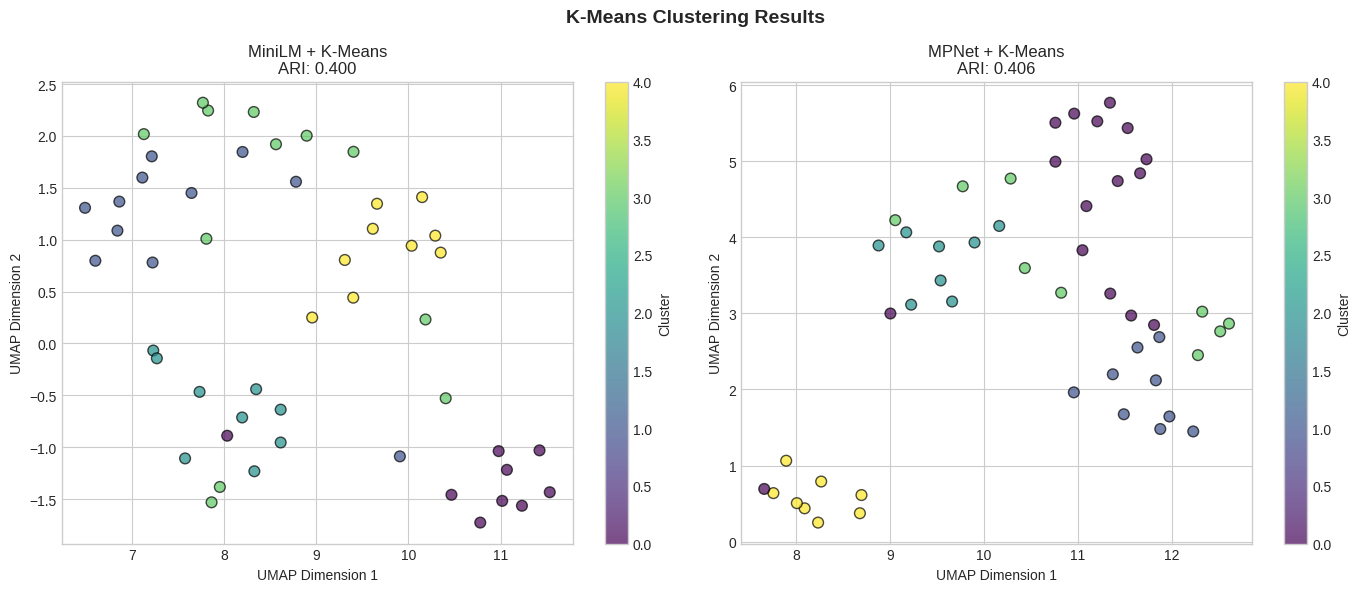

In [10]:
# Visualize clustering results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MiniLM clustering
scatter1 = axes[0].scatter(embeddings_minilm_2d[:, 0], embeddings_minilm_2d[:, 1],
                           c=labels_minilm, cmap='viridis', alpha=0.7, s=60, edgecolors='k')
axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')
axes[0].set_title(f'MiniLM + K-Means\nARI: {results[0]["ARI"]:.3f}')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# MPNet clustering
scatter2 = axes[1].scatter(embeddings_mpnet_2d[:, 0], embeddings_mpnet_2d[:, 1],
                           c=labels_mpnet, cmap='viridis', alpha=0.7, s=60, edgecolors='k')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')
axes[1].set_title(f'MPNet + K-Means\nARI: {results[1]["ARI"]:.3f}')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.suptitle('K-Means Clustering Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Hierarchical Clustering

In [11]:
# Apply Hierarchical Clustering
hclust_minilm = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_hclust_minilm = hclust_minilm.fit_predict(embeddings_minilm)

hclust_mpnet = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_hclust_mpnet = hclust_mpnet.fit_predict(embeddings_mpnet)

# Evaluate
results.append(evaluate_clustering(embeddings_minilm, labels_hclust_minilm, y_true, 'MiniLM + Hierarchical'))
results.append(evaluate_clustering(embeddings_mpnet, labels_hclust_mpnet, y_true, 'MPNet + Hierarchical'))

print("Hierarchical Clustering Results:")
print("="*70)
print(pd.DataFrame(results[2:]).to_string(index=False))

Hierarchical Clustering Results:
                Model      ARI      NMI  Silhouette  Calinski-Harabasz  Davies-Bouldin
MiniLM + Hierarchical 0.604600 0.699168    0.062000           2.946935        2.635576
 MPNet + Hierarchical 0.663329 0.776245    0.068321           3.039977        2.629339


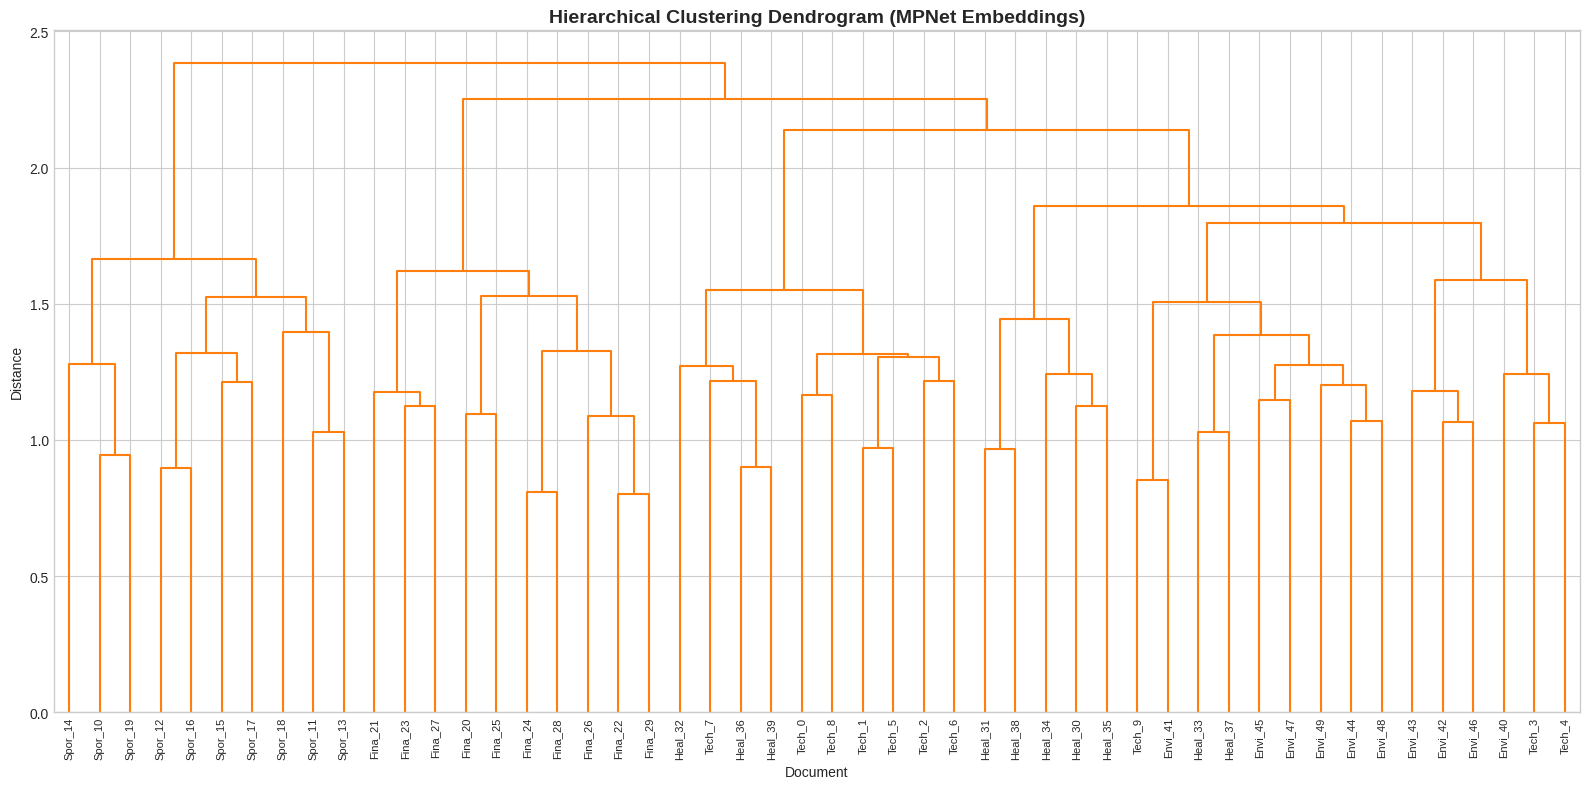

In [12]:
# Create dendrogram for document clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Use MPNet embeddings for dendrogram
Z = linkage(embeddings_mpnet, method='ward')

plt.figure(figsize=(16, 8))

# Create short labels
short_labels = [f"{cat[:4]}_{i}" for i, cat in enumerate(categories)]

dendrogram(Z, labels=short_labels, leaf_rotation=90, leaf_font_size=8,
           color_threshold=25)
plt.title('Hierarchical Clustering Dendrogram (MPNet Embeddings)', fontsize=14, fontweight='bold')
plt.xlabel('Document')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

## 7. HDBSCAN Clustering

In [13]:
# Apply HDBSCAN (density-based clustering)
hdbscan_minilm = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2)
labels_hdbscan_minilm = hdbscan_minilm.fit_predict(embeddings_minilm)

hdbscan_mpnet = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2)
labels_hdbscan_mpnet = hdbscan_mpnet.fit_predict(embeddings_mpnet)

print(f"HDBSCAN clusters found (MiniLM): {len(set(labels_hdbscan_minilm)) - (1 if -1 in labels_hdbscan_minilm else 0)}")
print(f"HDBSCAN clusters found (MPNet): {len(set(labels_hdbscan_mpnet)) - (1 if -1 in labels_hdbscan_mpnet else 0)}")
print(f"Noise points (MiniLM): {(labels_hdbscan_minilm == -1).sum()}")
print(f"Noise points (MPNet): {(labels_hdbscan_mpnet == -1).sum()}")

HDBSCAN clusters found (MiniLM): 2
HDBSCAN clusters found (MPNet): 2
Noise points (MiniLM): 11
Noise points (MPNet): 38


In [14]:
# Evaluate HDBSCAN (excluding noise points for some metrics)
def evaluate_hdbscan(embeddings, labels_pred, y_true, model_name):
    # Filter out noise for ARI/NMI calculation
    valid_mask = labels_pred >= 0

    if valid_mask.sum() > 0 and len(set(labels_pred[valid_mask])) > 1:
        ari = adjusted_rand_score(y_true[valid_mask], labels_pred[valid_mask])
        nmi = normalized_mutual_info_score(y_true[valid_mask], labels_pred[valid_mask])
        sil = silhouette_score(embeddings[valid_mask], labels_pred[valid_mask])
    else:
        ari, nmi, sil = 0, 0, 0

    n_clusters = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)
    n_noise = (labels_pred == -1).sum()

    return {
        'Model': model_name,
        'ARI': ari,
        'NMI': nmi,
        'Silhouette': sil,
        'N Clusters': n_clusters,
        'N Noise': n_noise
    }

hdbscan_results = []
hdbscan_results.append(evaluate_hdbscan(embeddings_minilm, labels_hdbscan_minilm, y_true, 'MiniLM + HDBSCAN'))
hdbscan_results.append(evaluate_hdbscan(embeddings_mpnet, labels_hdbscan_mpnet, y_true, 'MPNet + HDBSCAN'))

print("HDBSCAN Clustering Results:")
print("="*70)
print(pd.DataFrame(hdbscan_results).to_string(index=False))

HDBSCAN Clustering Results:
           Model      ARI      NMI  Silhouette  N Clusters  N Noise
MiniLM + HDBSCAN 0.204830 0.482678    0.074563           2       11
 MPNet + HDBSCAN 0.554913 0.707962    0.133010           2       38


## 8. Finding Optimal Number of Clusters

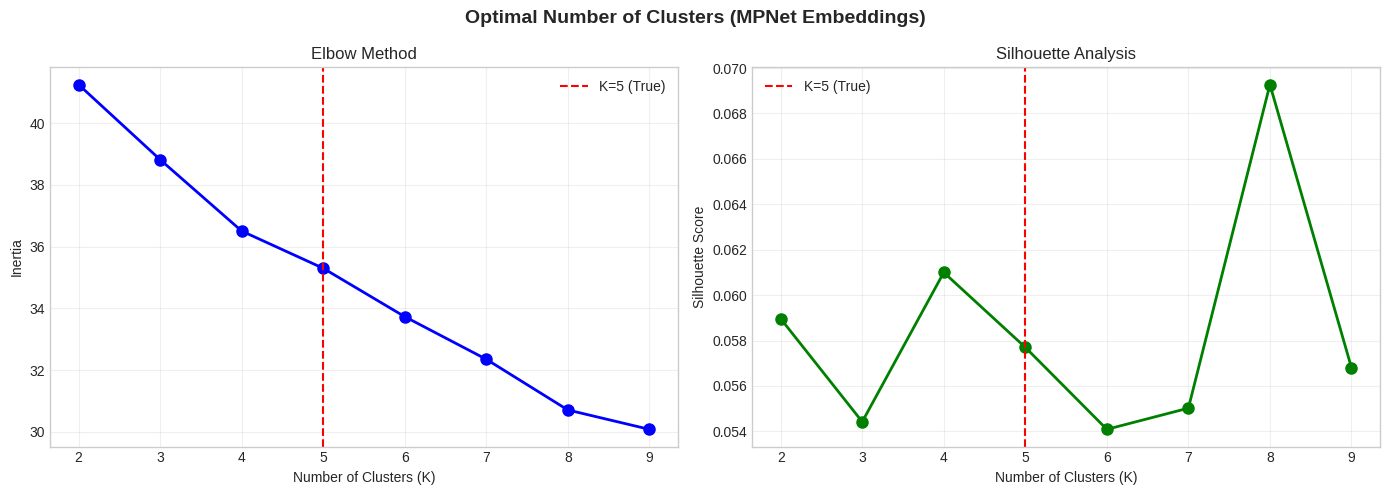


Optimal K by Silhouette: 8


In [15]:
# Elbow method and Silhouette analysis for optimal K
k_range = range(2, 10)
inertias = []
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings_mpnet)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(embeddings_mpnet, labels))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].axvline(x=5, color='red', linestyle='--', label='K=5 (True)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Silhouette curve
axes[1].plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].axvline(x=5, color='red', linestyle='--', label='K=5 (True)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Optimal Number of Clusters (MPNet Embeddings)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

optimal_k = list(k_range)[np.argmax(silhouettes)]
print(f"\nOptimal K by Silhouette: {optimal_k}")

## 9. Semantic Similarity Analysis

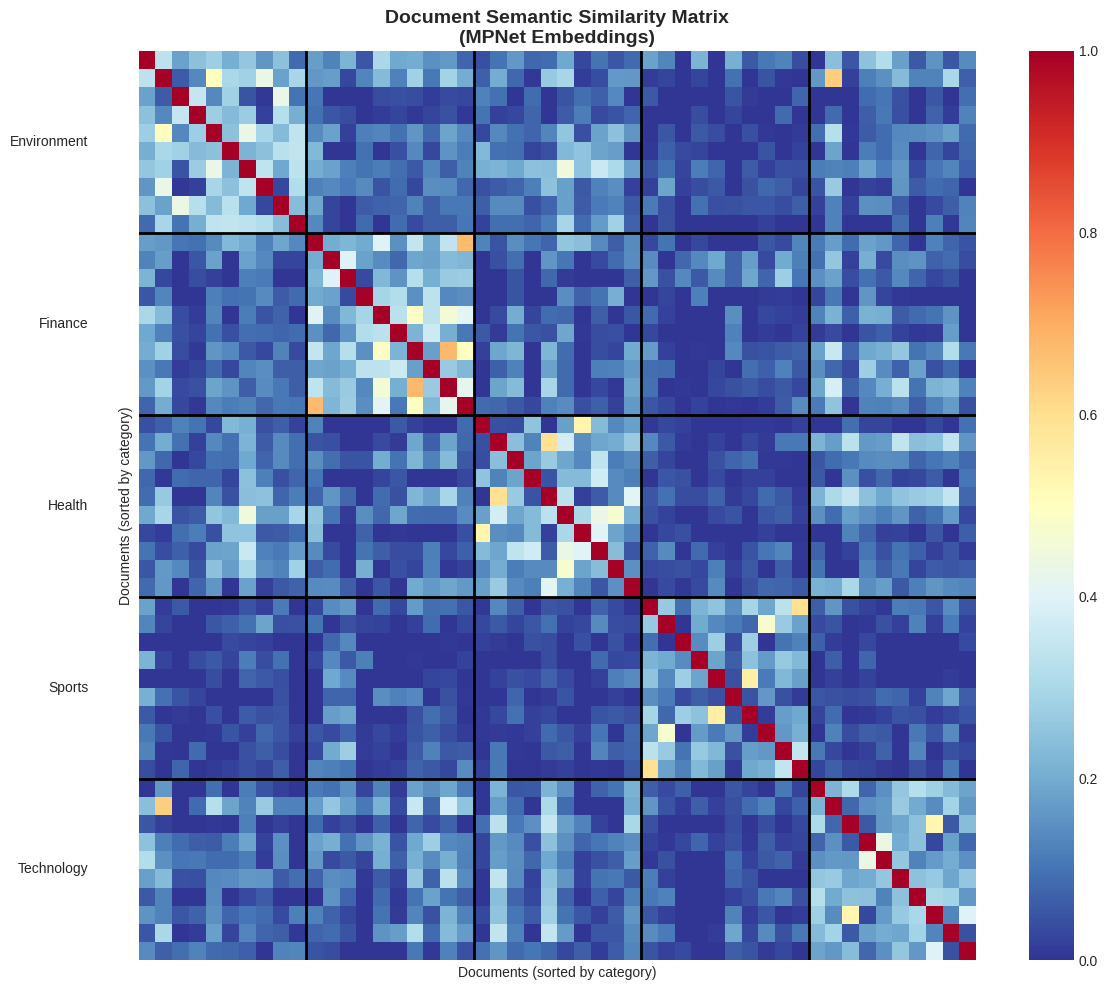

The diagonal blocks show high similarity within categories.


In [16]:
# Compute cosine similarity between documents
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings_mpnet)

# Create a heatmap
plt.figure(figsize=(12, 10))

# Sort documents by category for better visualization
sorted_indices = np.argsort(y_true)
sorted_similarity = similarity_matrix[sorted_indices][:, sorted_indices]

# Create labels
sorted_categories = np.array(categories)[sorted_indices]

sns.heatmap(sorted_similarity, cmap='RdYlBu_r',
            xticklabels=False, yticklabels=False,
            vmin=0, vmax=1)

# Add category separators
category_boundaries = [0, 10, 20, 30, 40, 50]
for boundary in category_boundaries[1:-1]:
    plt.axhline(y=boundary, color='black', linewidth=2)
    plt.axvline(x=boundary, color='black', linewidth=2)

plt.title('Document Semantic Similarity Matrix\n(MPNet Embeddings)', fontsize=14, fontweight='bold')
plt.xlabel('Documents (sorted by category)')
plt.ylabel('Documents (sorted by category)')

# Add category labels
for i, cat in enumerate(le.classes_):
    plt.text(-3, 5 + i*10, cat, fontsize=10, rotation=0, ha='right', va='center')

plt.tight_layout()
plt.show()

print("The diagonal blocks show high similarity within categories.")

## 10. Cluster Interpretation

In [17]:
# Analyze what each cluster contains
df['cluster_kmeans'] = labels_mpnet

print("Cluster Analysis (MPNet + K-Means):")
print("="*70)

for cluster in range(n_clusters):
    cluster_docs = df[df['cluster_kmeans'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_docs)} documents):")
    print(f"  Category distribution: {cluster_docs['category'].value_counts().to_dict()}")
    print(f"  Sample documents:")
    for doc in cluster_docs['document'].head(2):
        print(f"    - {doc[:80]}...")

Cluster Analysis (MPNet + K-Means):

Cluster 0 (16 documents):
  Category distribution: {'Technology': 8, 'Environment': 3, 'Health': 3, 'Finance': 1, 'Sports': 1}
  Sample documents:
    - The new smartphone features an advanced AI chip for better performance....
    - Machine learning algorithms are transforming how we process data....

Cluster 1 (9 documents):
  Category distribution: {'Health': 7, 'Environment': 2}
  Sample documents:
    - Regular exercise improves cardiovascular health and mental wellbeing....
    - A balanced diet is essential for maintaining good health....

Cluster 2 (8 documents):
  Category distribution: {'Finance': 8}
  Sample documents:
    - Stock market indices reached new all-time highs this quarter....
    - Interest rates remain stable despite economic uncertainty....

Cluster 3 (9 documents):
  Category distribution: {'Environment': 5, 'Technology': 2, 'Sports': 1, 'Finance': 1}
  Sample documents:
    - Cybersecurity threats continue to evolve with 

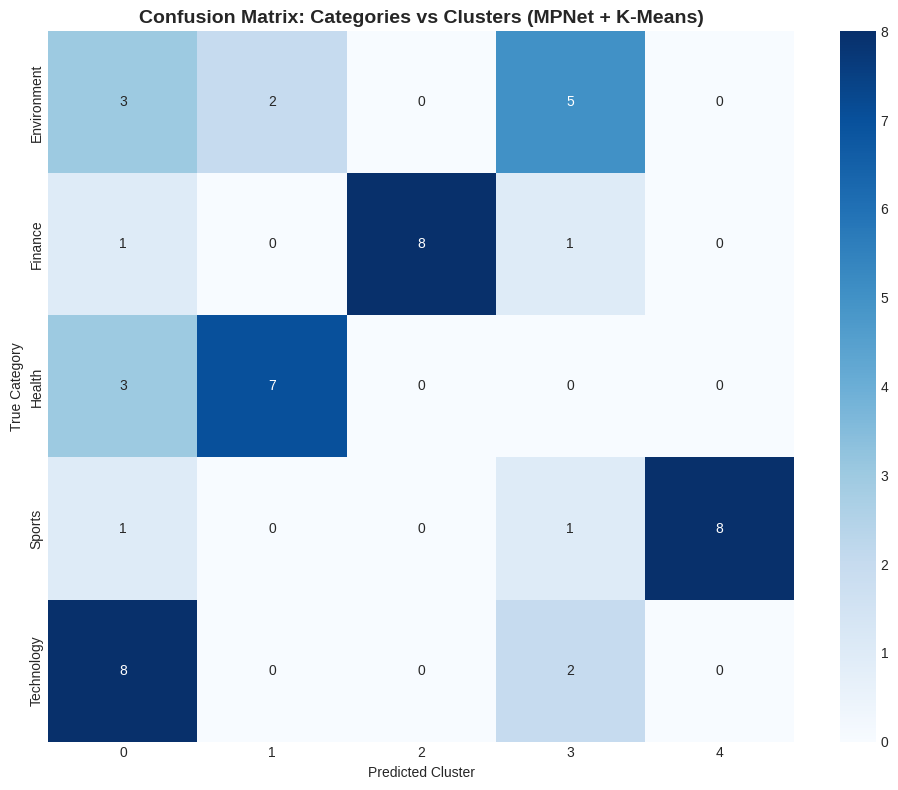

In [18]:
# Confusion matrix: True Category vs Predicted Cluster
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, labels_mpnet)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(5), yticklabels=le.classes_)
plt.xlabel('Predicted Cluster')
plt.ylabel('True Category')
plt.title('Confusion Matrix: Categories vs Clusters (MPNet + K-Means)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Comprehensive Results Summary

In [19]:
# Combine all results
all_results = pd.DataFrame(results)

print("="*80)
print("COMPREHENSIVE DOCUMENT CLUSTERING RESULTS")
print("="*80)
print("\nAll Methods Comparison:")
print(all_results.to_string(index=False))

# Best performing method
best_method = all_results.loc[all_results['ARI'].idxmax()]
print(f"\nBest performing method: {best_method['Model']}")
print(f"ARI: {best_method['ARI']:.4f}, NMI: {best_method['NMI']:.4f}")

COMPREHENSIVE DOCUMENT CLUSTERING RESULTS

All Methods Comparison:
                Model      ARI      NMI  Silhouette  Calinski-Harabasz  Davies-Bouldin
     MiniLM + K-Means 0.399801 0.536258    0.052122           2.725341        2.962457
      MPNet + K-Means 0.405600 0.556720    0.057699           2.815805        2.783338
MiniLM + Hierarchical 0.604600 0.699168    0.062000           2.946935        2.635576
 MPNet + Hierarchical 0.663329 0.776245    0.068321           3.039977        2.629339

Best performing method: MPNet + Hierarchical
ARI: 0.6633, NMI: 0.7762


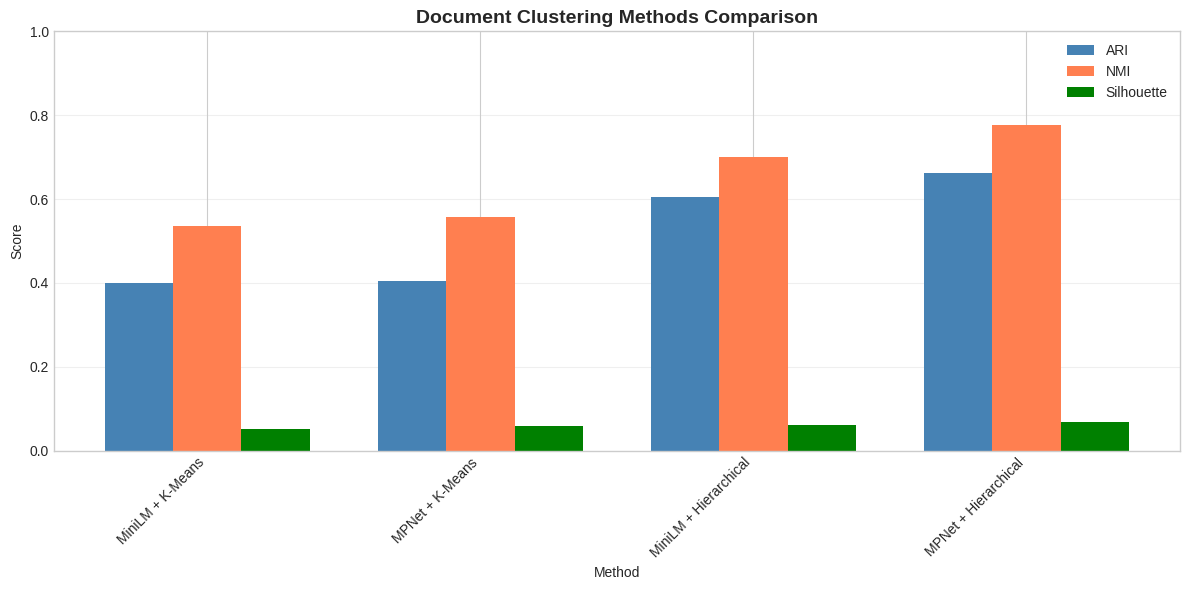

In [20]:
# Visualize results comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(all_results))
width = 0.25

bars1 = ax.bar(x - width, all_results['ARI'], width, label='ARI', color='steelblue')
bars2 = ax.bar(x, all_results['NMI'], width, label='NMI', color='coral')
bars3 = ax.bar(x + width, all_results['Silhouette'], width, label='Silhouette', color='green')

ax.set_xlabel('Method')
ax.set_ylabel('Score')
ax.set_title('Document Clustering Methods Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(all_results['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [21]:
print("="*70)
print("DOCUMENT CLUSTERING WITH LLM EMBEDDINGS - SUMMARY")
print("="*70)

print("\n1. EMBEDDING MODELS USED:")
print("   - all-MiniLM-L6-v2: Fast, 384-dimensional embeddings")
print("   - all-mpnet-base-v2: Higher quality, 768-dimensional embeddings")

print("\n2. CLUSTERING ALGORITHMS:")
print("   - K-Means: Partition-based clustering")
print("   - Hierarchical: Agglomerative clustering with Ward linkage")
print("   - HDBSCAN: Density-based clustering")

print("\n3. QUALITY METRICS:")
print("   - Adjusted Rand Index (ARI): Agreement with ground truth")
print("   - Normalized Mutual Information (NMI): Information overlap")
print("   - Silhouette Score: Cluster cohesion and separation")
print("   - Calinski-Harabasz Index: Variance ratio criterion")
print("   - Davies-Bouldin Index: Cluster similarity measure")

print("\n4. DATASET:")
print(f"   - {len(documents)} documents")
print(f"   - {len(le.classes_)} categories: {', '.join(le.classes_)}")

print("\n5. KEY FINDINGS:")
print(f"   - Best method: {best_method['Model']}")
print("   - LLM embeddings effectively capture semantic meaning")
print("   - Documents from same category cluster together")
print("   - MPNet provides slightly better embeddings than MiniLM")

print("\n6. RECOMMENDATIONS:")
print("   - Use MPNet for higher quality (when speed is not critical)")
print("   - Use MiniLM for faster processing (large document sets)")
print("   - Visualize with UMAP to verify cluster structure")
print("   - Use silhouette analysis to find optimal K")

print("\n" + "="*70)

DOCUMENT CLUSTERING WITH LLM EMBEDDINGS - SUMMARY

1. EMBEDDING MODELS USED:
   - all-MiniLM-L6-v2: Fast, 384-dimensional embeddings
   - all-mpnet-base-v2: Higher quality, 768-dimensional embeddings

2. CLUSTERING ALGORITHMS:
   - K-Means: Partition-based clustering
   - Hierarchical: Agglomerative clustering with Ward linkage
   - HDBSCAN: Density-based clustering

3. QUALITY METRICS:
   - Adjusted Rand Index (ARI): Agreement with ground truth
   - Normalized Mutual Information (NMI): Information overlap
   - Silhouette Score: Cluster cohesion and separation
   - Calinski-Harabasz Index: Variance ratio criterion
   - Davies-Bouldin Index: Cluster similarity measure

4. DATASET:
   - 50 documents
   - 5 categories: Environment, Finance, Health, Sports, Technology

5. KEY FINDINGS:
   - Best method: MPNet + Hierarchical
   - LLM embeddings effectively capture semantic meaning
   - Documents from same category cluster together
   - MPNet provides slightly better embeddings than MiniLM

